# Spectroscopy Function Tests

This notebook provides extensive testing for all functions within the spectroscopy module, ensuring they handle various scenarios correctly and identifying areas for improvement.

### **Core Functions Tested:**
Inhomogenity:
- `normalized_gauss(detunings, fwhm_val)` - Normalized Gaussian distribution for inhomogeneous broadening
- `sample_from_sigma(n_samples, fwhm_val, max_detuning)` - Rejection sampling from Gaussian distribution

Spolvers:
- `check_the_solver(rho)` - Density matrix validation (Hermitian, positive semidefinite, unit trace)

1D Data:
- `compute_1d_polarization` - 1D fixed tau_coh, T_wait:

2D Spectroscopy:
- `get_tau_cohs_and_t_dets_for_T_wait(T_wait, dt, tau_coh_max, t_det_max)` - Time array generation
- `compute_2d_polarization(tau_cohs, t_dets, T_wait, pulse_sequence, params)`

Post Processing:
- `compute_2d_fft_wavenumber(t_dets, tau_cohs, data)` - 2D spectra computation
- `extend_and_plot(...)`
---
**Last Updated:** May 30, 2025

In [ ]:
# =============================
# IMPORT NECESSARY MODULES
# =============================

### Standard scientific libraries
import numpy as np
import time
import warnings
import traceback
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt

### QuTiP quantum toolkit
import qutip as qt
from qutip import mesolve, brmesolve

### Local spectroscopy modules - Core
from qspectro2d.core.system_parameters import SystemParameters
from qspectro2d.core.pulse_sequences import PulseSequence, Pulse
from qspectro2d.core.solver_fcts import matrix_ODE_paper, R_paper
from qspectro2d.core.functions_with_rwa import H_int, get_expect_vals_with_RWA, apply_RWA_phase_factors
from qspectro2d.core.pulse_functions import identify_non_zero_pulse_regions, split_by_active_regions

### Local spectroscopy modules - Calculations
from qspectro2d.spectroscopy.calculations import (
    complex_polarization,
    compute_pulse_evolution,
    check_the_solver,
    compute_1d_polarization,
    parallel_compute_1d_E_with_inhomogenity,
    parallel_compute_2d_E_with_inhomogenity,
    extract_ift_signal_component,
    _process_single_1d_combination,
    _get_pulse_timings,
    _create_pulse_sequences,
    _compute_three_pulse_evolution,
    _compute_linear_signals,
)

### Local spectroscopy modules - Inhomogeneity
from qspectro2d.spectroscopy.inhomogenity import (
    sample_from_sigma,
    normalized_gauss
)

### Local spectroscopy modules - Post-processing
from qspectro2d.spectroscopy.post_processing import (
    compute_1d_fft_wavenumber, 
    compute_2d_fft_wavenumber, 
)

### Local visualization modules
from qspectro2d.visualization.plotting import (
    plot_example_polarization, 
    plot_2d_el_field, 
    plot_example_evo, 
)

### Configuration
from config.mpl_tex_settings import *

print("✓ All imports successful!")

N_atoms_test = 1

✔️ Using font: Palatino Linotype
✓ All imports successful!
✓ All imports successful!


## Test 1: inhomogeneous broadening

Testing sigma function (normalized Gaussian distribution)...

Testing sample_from_sigma function (rejection sampling)...
Sample statistics: mean = -0.008148, std = 0.844826
Expected: mean ≈ 0, std ≈ 0.849322
Sample statistics: mean = -0.008148, std = 0.844826
Expected: mean ≈ 0, std ≈ 0.849322


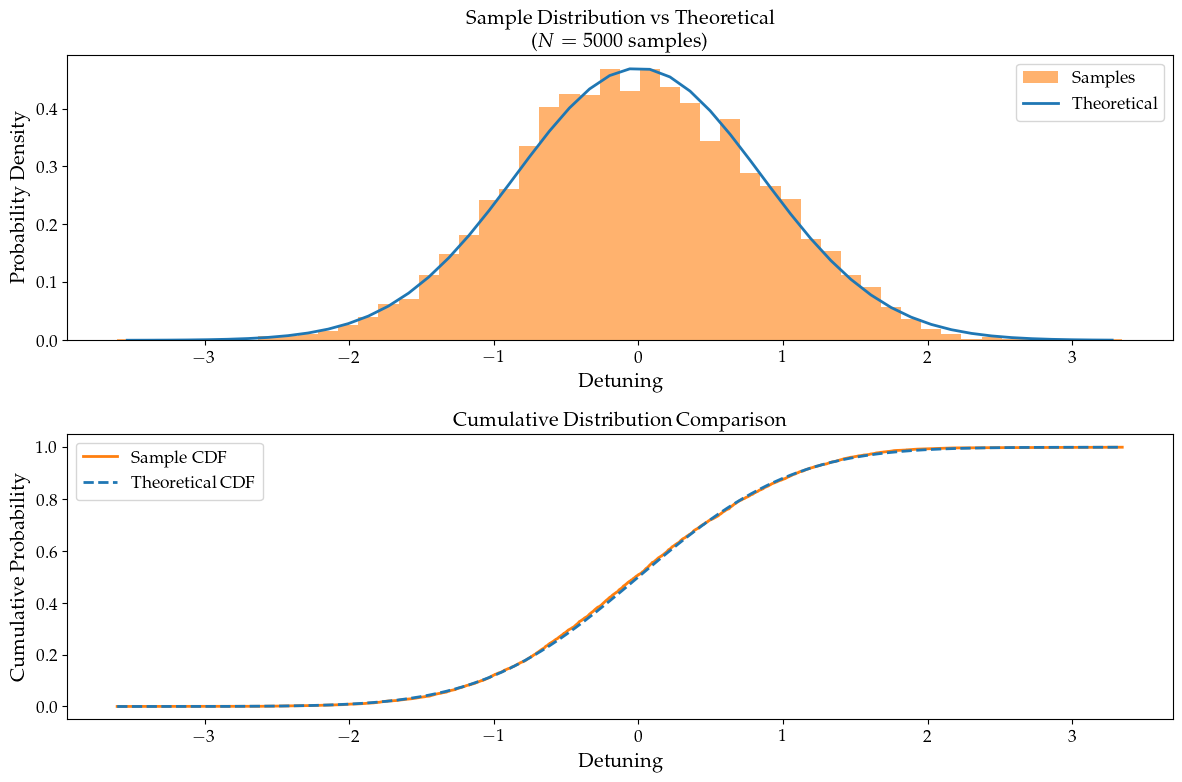

In [2]:
### Test sigma function (normalized Gaussian)
print("Testing sigma function (normalized Gaussian distribution)...")

# Test basic functionality
detunings = np.linspace(-5, 5, 40000)
fwhm_val = 2.0
sigma_val = fwhm_val / (2 * np.sqrt(2 * np.log(2)))  # standard deviation from fwhm

### Test sample_from_sigma function
print("\nTesting sample_from_sigma function (rejection sampling)...")
n_samples = 5000

# Generate samples
samples = sample_from_sigma(n_samples, fwhm_val, mu=0, max_detuning=3.0)

# Test statistical properties
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print(f"Sample statistics: mean = {sample_mean:.6f}, std = {sample_std:.6f}")
print(f"Expected: mean ≈ 0, std ≈ {fwhm_val / (2 * np.sqrt(2 * np.log(2))) :.6f}")

### Visualization of sampling results
plt.figure(figsize=(12, 8))

# Plot 2: Sample histogram vs theoretical
plt.subplot(2, 1, 1)
hist_counts, hist_bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.6, 
                                   color='C1', label='Samples')
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
theoretical = normalized_gauss(bin_centers, fwhm_val, mu=0)
# Test normalization (integral should be approximately 1)

plt.plot(bin_centers, theoretical, 'C0', linewidth=2, label='Theoretical')
plt.xlabel(r'Detuning')
plt.ylabel('Probability Density')
plt.title(f'Sample Distribution vs Theoretical\n($N = {n_samples}$ samples)')
plt.legend()

# Plot 3: Cumulative distribution comparison
plt.subplot(2, 1, 2)
sorted_samples = np.sort(samples)
cumulative = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, cumulative, 'C1', label='Sample CDF', linewidth=2)

# Theoretical CDF (using scipy for accuracy)
theoretical_cdf = norm.cdf(sorted_samples, 0, sigma_val)
plt.plot(sorted_samples, theoretical_cdf, 'C0--', label='Theoretical CDF', linewidth=2)
plt.xlabel(r'Detuning')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Comparison')
plt.legend()

## Test 2: checking all solverS (compute_pulse_evolution)

In [3]:
# =============================
# TEST 2: SOLVER VALIDATION (CHECK_THE_SOLVER)
# =============================

### Test check_the_solver function
print("Testing check_the_solver function...")

### Create test system
system_test = SystemParameters(
    N_atoms=1,
    t_max=100.0,
    dt=0.5,
    E0=0.05,
    pulse_fwhm=15.0,
    Temp=0.1,
    ODE_Solver="Paper_BR"  # Start with one that should work
)

try:
    result, runtime = check_the_solver(system_test)
    print(f"✓ Solver validation successful!")
    print(f"  - Runtime: {runtime:.4f} seconds")
    print(f"  - Final state trace: {result.states[-1].tr():.6f}")
    print(f"  - Number of time steps: {len(result.times)}")
    print(f"  - Time range: {result.times[0]:.2f} to {result.times[-1]:.2f} fs")
    
    # Check physical properties
    final_state = result.states[-1]
    print(f"  - Final state is Hermitian: {final_state.isherm}")
    print(f"  - Final state eigenvalues: {np.real(final_state.eigenenergies())}")
    
except Exception as e:
    print(f"✗ Error in solver validation: {e}")
    import traceback
    traceback.print_exc()

Testing check_the_solver function...
Checking 'Paper_BR' solver 


Checks passed. DM remains Hermitian and positive.
✓ Solver validation successful!
  - Runtime: inf seconds
  - Final state trace: 1.000000
  - Number of time steps: 43
  - Time range: -15.00 to 195.00 fs
  - Final state is Hermitian: True
  - Final state eigenvalues: [0.39884087 0.60115913]
✓ Solver validation successful!
  - Runtime: inf seconds
  - Final state trace: 1.000000
  - Number of time steps: 43
  - Time range: -15.00 to 195.00 fs
  - Final state is Hermitian: True
  - Final state eigenvalues: [0.39884087 0.60115913]


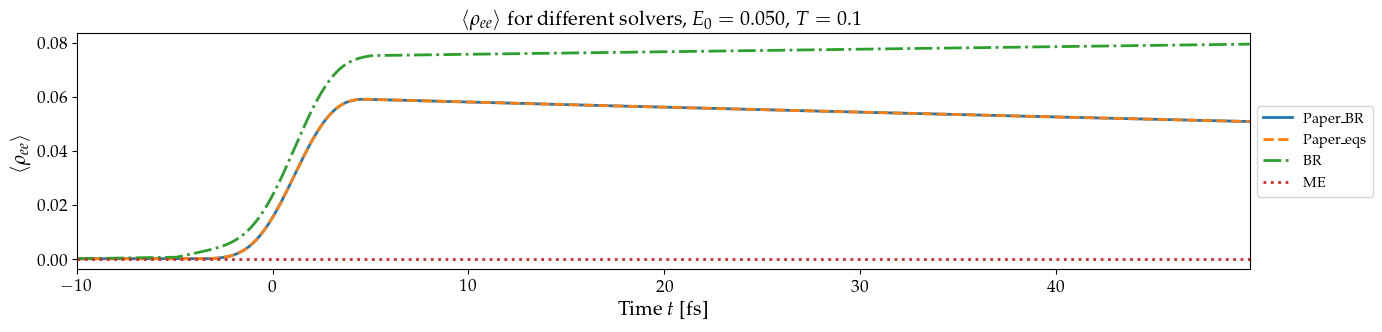

In [4]:
from qspectro2d.core.functions_with_rwa import apply_RWA_phase_factors
# =============================
# MULTI-SOLVER DECAY COMPARISON
# =============================

### Setup test parameters
solvers = [
    "Paper_BR", 
    "Paper_eqs", 
    "BR",
    "ME"
]
colors  = ['C0', 'C1', 'C2', 'C3']
styles  = ['solid', 'dashed', 'dashdot', 'dotted']

### Create initial state
if N_atoms_test == 1:
    psi_0_test = qt.basis(2, 0)  # Initial state |g⟩
elif N_atoms_test == 2:
    psi_0_test = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))  # |gg⟩

### Create system parameters
system_current = SystemParameters(
    N_atoms=N_atoms_test,
    t_max=50.0,
    dt=0.1,
    envelope_type="cos2",
    pulse_fwhm=5.0,
    E0=0.05,
    RWA_laser=True,
    Temp=1e-1,
    ODE_Solver="Paper_BR"  # Default solver
)

### Create observable operators and labels
if N_atoms_test == 1:
    e_ops = [system_current.atom_e * system_current.atom_e.dag()]  # Population of excited state
    labels = [r'\rho_{ee}']
elif N_atoms_test == 2:
    # Two-atom observables
    e_ops = []
    labels = []
    for i in range(4):  # For 2 atoms, we have 4 states
        for j in range(4):
            e_ops.append(system_current.eigenstates[1][i] * system_current.eigenstates[1][j].dag())
            labels.append(f'\\rho_{{{i}{j}}}')

### Create test pulse sequence using from_pulse_specs
test_sequence = PulseSequence.from_pulse_specs(
    system=system_current, 
    pulse_specs=[(0, 0.0, 0.0)]  # pulse_index=0, t_peak=0.0, phase=0.0
)

### Create time array
times = np.arange(-10, system_current.t_max, system_current.dt)

### Plot results for different solvers
plt.figure(figsize=(14, 3.5 * min(len(e_ops), 4)))  # Limit to first 4 observables

for j, (e_op, label) in enumerate(zip(e_ops[:4], labels[:4])):  # Only plot first 4
    plt.subplot(min(len(e_ops), 4), 1, j + 1)
    
    for i, solver in enumerate(solvers):
        try:
            # Update system solver
            system_current.ODE_Solver = solver
            
            # Compute evolution
            result = compute_pulse_evolution(
                psi_ini=system_current.psi_ini, 
                times=times, 
                pulse_seq=test_sequence, 
                system=system_current
            )
            
            # Apply RWA phase factors if needed
            states = apply_RWA_phase_factors(result.states, times, system=system_current)
            
            # Calculate expectation values
            expectations = qt.expect(e_op, states)
            
            plt.plot(
                times, expectations,
                label=f'{solver}',
                color=colors[i % len(colors)],
                linestyle=styles[i % len(styles)],
                linewidth=2
            )
            
        except Exception as e:
            print(f"Error with solver {solver}: {e}")
            
    plt.xlabel(r'Time $t$ [fs]')
    plt.ylabel(f'$\\langle {label} \\rangle$')
    plt.title(f'$\\langle {label} \\rangle$ for different solvers, $E_0 = {system_current.E0:.3f}$, $T = {system_current.Temp}$')
    plt.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(times[0], times[-1])

plt.tight_layout()
plt.show()

In [5]:
a_op, J = system_current.br_decay_channels[1]
print(f"J(omega_A) = {J(system_current.omega_A)}")
a_op, J = system_current.br_decay_channels[0]
print(f"J(omega_A) = {J(0)}")

# =============================
# TEST 3: COMPLEX POLARIZATION FUNCTION
# =============================

### Test complex_polarization function with different quantum states
print("Testing complex_polarization function...")

### Create test states
rho_ground = qt.ket2dm(system_current.atom_g)  # Ground state density matrix
rho_excited = qt.ket2dm(system_current.atom_e)  # Excited state density matrix
rho_coherent = 0.5 * (rho_ground + rho_excited + 
                      system_current.atom_g * system_current.atom_e.dag() + 
                      system_current.atom_e * system_current.atom_g.dag())  # Coherent superposition

### Test single state polarization
try:
    pol_ground = complex_polarization(system_current, rho_ground)
    pol_excited = complex_polarization(system_current, rho_excited)
    pol_coherent = complex_polarization(system_current, rho_coherent)
    
    print(f"✓ Single state polarizations computed:")
    print(f"  - Ground state: {pol_ground:.6f}")
    print(f"  - Excited state: {pol_excited:.6f}")
    print(f"  - Coherent state: {pol_coherent:.6f}")
    
except Exception as e:
    print(f"✗ Error in single state polarization: {e}")

### Test multiple states polarization
try:
    states_list = [rho_ground, rho_excited, rho_coherent]
    pol_array = complex_polarization(system_current, states_list)
    
    print(f"✓ Multiple state polarizations computed:")
    print(f"  - Array shape: {pol_array.shape}")
    print(f"  - Values: {pol_array}")
    
except Exception as e:
    print(f"✗ Error in multiple state polarization: {e}")

### Test with ket states (if supported)
try:
    psi_ground = system_current.atom_g
    psi_excited = system_current.atom_e
    
    pol_ket_ground = complex_polarization(system_current, psi_ground)
    pol_ket_excited = complex_polarization(system_current, psi_excited)
    
    print(f"✓ Ket state polarizations computed:")
    print(f"  - Ground ket: {pol_ket_ground:.6f}")
    print(f"  - Excited ket: {pol_ket_excited:.6f}")
    
except Exception as e:
    print(f"✗ Error in ket state polarization: {e}")

print("Complex polarization tests completed.\n")

J(omega_A) = 0.0033333333333333327
J(omega_A) = 0.011666666666666667
Testing complex_polarization function...
✓ Single state polarizations computed:
  - Ground state: 0.000000+0.000000j
  - Excited state: 0.000000+0.000000j
  - Coherent state: 0.500000+0.000000j
✓ Multiple state polarizations computed:
  - Array shape: (3,)
  - Values: [0. +0.j 0. +0.j 0.5+0.j]
✗ Error in ket state polarization: index 1 is out of bounds for axis 1 with size 1
Complex polarization tests completed.



In [6]:
from qutip import *

g = basis(2,0)
e = basis(2,1)
g_qtp = e
e_qtp = g
sz = ket2dm(e) - ket2dm(g)
sz_qtp = ket2dm(e_qtp) - ket2dm(g_qtp)
print("comparison of the different basis defintions: sz, sz like i excpect it to be in qutip, how it actually is in qutip", sz, sz_qtp, sigmaz())

# =============================
# TEST 4: PULSE SEQUENCE CREATION AND PROPERTIES
# =============================

### Test pulse sequence creation
print("Testing PulseSequence creation and properties...")

### Create individual pulse
try:
    single_pulse = Pulse(
        pulse_peak_time=10.0,
        pulse_fwhm=5.0,
        pulse_phase=0.0,
        pulse_amplitude=system_current.E0,
        pulse_freq=system_current.omega_laser,
        pulse_index=0,
        envelope_type="cos2"
    )
    
    print(f"✓ Single pulse created:")
    print(f"  - Peak time: {single_pulse.pulse_peak_time} fs")
    print(f"  - FWHM: {single_pulse.pulse_fwhm} fs")
    print(f"  - Active range: {single_pulse.active_time_range}")
    print(f"  - Phase: {single_pulse.pulse_phase} rad")
    
except Exception as e:
    print(f"✗ Error creating single pulse: {e}")

### Create pulse sequence from system parameters using from_pulse_specs
try:
    pulse_sequence = PulseSequence.from_pulse_specs(
        system=system_current,
        pulse_specs=[(0, 0.0, 0.0)]  # pulse_index=0, t_peak=0.0, phase=0.0
    )
    
    print(f"✓ PulseSequence created from system:")
    print(f"  - Number of pulses: {len(pulse_sequence.pulses)}")
    if hasattr(pulse_sequence, 'total_duration'):
        print(f"  - Total duration: {pulse_sequence.total_duration:.2f} fs")
    if hasattr(pulse_sequence, 'time_range'):
        print(f"  - Time range: {pulse_sequence.time_range}")
    
    # Test pulse sequence properties
    if len(pulse_sequence.pulses) > 0:
        first_pulse = pulse_sequence.pulses[0]
        print(f"  - First pulse peak: {first_pulse.pulse_peak_time} fs")
        print(f"  - First pulse FWHM: {first_pulse.pulse_fwhm} fs")
        
except Exception as e:
    print(f"✗ Error creating pulse sequence: {e}")

### Test pulse sequence with multiple pulses using from_pulse_specs
try:
    # Create a three-pulse sequence for 2D spectroscopy
    tau_coh = 100.0  # Coherence time
    T_wait = 200.0   # Waiting time
    
    # Define pulse timings for a three-pulse sequence
    pulse_specs = [
        (0, 0.0, 0.0),           # First pulse at t=0, phase=0
        (1, tau_coh, 0.0),       # Second pulse at t=tau_coh, phase=0  
        (2, tau_coh + T_wait, 0.0)  # Third pulse at t=tau_coh+T_wait, phase=0
    ]
    
    multi_pulse_seq = PulseSequence.from_pulse_specs(
        system=system_current,
        pulse_specs=pulse_specs
    )
    
    print(f"✓ Three-pulse sequence created:")
    print(f"  - Number of pulses: {len(multi_pulse_seq.pulses)}")
    if hasattr(multi_pulse_seq, 'total_duration'):
        print(f"  - Total duration: {multi_pulse_seq.total_duration:.2f} fs")
    
    for i, pulse in enumerate(multi_pulse_seq.pulses):
        print(f"  - Pulse {i+1}: t_peak = {pulse.pulse_peak_time:.1f} fs, phase = {pulse.pulse_phase:.2f} rad")
        
except Exception as e:
    print(f"✗ Error creating three-pulse sequence: {e}")

### Test convenience method create_sequence (if it exists)
try:
    print("Testing create_sequence convenience method...")
    
    convenience_seq = PulseSequence.create_sequence(
        system=system_current,
        times=[0.0, 50.0, 150.0],
        phases=[0.0, np.pi/4, np.pi/2]
    )
    
    print(f"✓ Convenience sequence created:")
    print(f"  - Number of pulses: {len(convenience_seq.pulses)}")
    
    for i, pulse in enumerate(convenience_seq.pulses):
        print(f"  - Pulse {i+1}: t_peak = {pulse.pulse_peak_time:.1f} fs, phase = {pulse.pulse_phase:.2f} rad")
        
except Exception as e:
    print(f"✗ Error with create_sequence (may not be implemented): {e}")

print("Pulse sequence tests completed.\n")


comparison of the different basis defintions: sz, sz like i excpect it to be in qutip, how it actually is in qutip Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.  0.]
 [ 0.  1.]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Testing PulseSequence creation and properties...
✓ Single pulse created:
  - Peak time: 10.0 fs
  - FWHM: 5.0 fs
  - Active range: (5.0, 15.0)
  - Phase: 0.0 rad
✓ PulseSequence created from system:
  - Number of pulses: 1
  - First pulse peak: 0.0 fs
  - First pulse FWHM: 5.0 fs
✓ Three-pulse sequence created:
  - Number of pulses: 3
  - Pulse 1: t_peak = 0.0 fs, phase = 0.00 rad
  - Pulse 2: t_peak = 100.0 fs, phase = 0.00 rad
  - Pulse 3: t_peak = 300.0 fs, phase = 0.00 rad
Testing create_sequence convenience method...

In [7]:
from qspectro2d.core.pulse_functions import E_pulse
print(f"max Et = {np.max(np.abs([E_pulse(t, test_sequence) for t in times]))}")

system_current.H0_diagonalized, system_current.mu_A

# =============================
# TEST 5: 1D SPECTROSCOPY CALCULATIONS
# =============================

### Test 1D polarization computation
print("Testing 1D spectroscopy calculations...")

### Setup test parameters for 1D spectroscopy
tau_coh_test = 50.0  # Coherence time [fs]
T_wait_test = 100.0  # Waiting time [fs]
phi_0_test = 0.0     # Phase of first pulse [rad]
phi_1_test = np.pi/4 # Phase of second pulse [rad]

### Create time array for evolution
times_1d = np.arange(-20, tau_coh_test + T_wait_test + 50, 0.5)

### Create test system for 1D spectroscopy
system_1d = SystemParameters(
    N_atoms=1,
    t_max=tau_coh_test + T_wait_test + 50.0,
    dt=0.5,
    E0=0.02,  # Smaller field for linear regime
    pulse_fwhm=10.0,
    Temp=0.1,
    ODE_Solver="Paper_BR"
)

print(f"Test parameters:")
print(f"  - tau_coh: {tau_coh_test} fs")
print(f"  - T_wait: {T_wait_test} fs")
print(f"  - Phase 1: {phi_0_test:.3f} rad")
print(f"  - Phase 2: {phi_1_test:.3f} rad")
print(f"  - Time points: {len(times_1d)}")
print(f"  - E0: {system_1d.E0}")

### Test simple pulse sequence creation for 1D
try:
    # Create a simple test pulse sequence for 1D spectroscopy (two pulses)
    pulse_specs_1d = [
        (0, 0.0, phi_0_test),                    # First pulse at t=0
        (1, tau_coh_test, phi_1_test)            # Second pulse at t=tau_coh
    ]
    
    test_pulse_seq_1d = PulseSequence.from_pulse_specs(
        system=system_1d,
        pulse_specs=pulse_specs_1d
    )
    
    print(f"✓ 1D pulse sequence created:")
    print(f"  - Number of pulses: {len(test_pulse_seq_1d.pulses)}")
    
    for i, pulse in enumerate(test_pulse_seq_1d.pulses):
        print(f"  - Pulse {i+1}: t_peak = {pulse.pulse_peak_time:.1f} fs, phase = {pulse.pulse_phase:.3f} rad")
        
except Exception as e:
    print(f"✗ Error creating 1D pulse sequence: {e}")

### Test compute_1d_polarization function
try:
    # Test basic 1D polarization computation
    result_1d = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times_1d,
        system=system_1d
    )
    
    print(f"✓ compute_1d_polarization successful:")
    print(f"  - Result type: {type(result_1d)}")
    
    if isinstance(result_1d, (list, tuple)) and len(result_1d) >= 2:
        times_result, polarization_data = result_1d[0], result_1d[1]
        print(f"  - Time points: {len(times_result)}")
        print(f"  - Polarization shape: {np.array(polarization_data).shape}")
        print(f"  - Max polarization magnitude: {np.max(np.abs(polarization_data)):.6f}")
        
        # Quick plot of the result
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(times_result, np.real(polarization_data), 'C0', label='Real')
        plt.plot(times_result, np.imag(polarization_data), 'C1', label='Imaginary')
        plt.xlabel('Time [fs]')
        plt.ylabel('Polarization')
        plt.title(f'1D Polarization\\n$\\tau_{{coh}}$ = {tau_coh_test} fs, $T_{{wait}}$ = {T_wait_test} fs')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(times_result, np.abs(polarization_data), 'C2', label='Magnitude')
        plt.xlabel('Time [fs]')
        plt.ylabel('|Polarization|')
        plt.title('Polarization Magnitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"  - Unexpected result format: {result_1d}")
        
except Exception as e:
    print(f"✗ Error in compute_1d_polarization: {e}")
    import traceback
    traceback.print_exc()

print("1D spectroscopy tests completed.\n")

max Et = 0.05
Testing 1D spectroscopy calculations...
Test parameters:
  - tau_coh: 50.0 fs
  - T_wait: 100.0 fs
  - Phase 1: 0.000 rad
  - Phase 2: 0.785 rad
  - Time points: 440
  - E0: 0.02
✓ 1D pulse sequence created:
  - Number of pulses: 2
  - Pulse 1: t_peak = 0.0 fs, phase = 0.000 rad
  - Pulse 2: t_peak = 50.0 fs, phase = 0.785 rad
✗ Error in compute_1d_polarization: compute_1d_polarization() missing 1 required positional argument: 't_det_max'
1D spectroscopy tests completed.



Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\2867225576.py", line 66, in <module>
    result_1d = compute_1d_polarization(
                ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: compute_1d_polarization() missing 1 required positional argument: 't_det_max'


In [8]:
from qutip import *

size = 2 # 2 states |g>, |e>

idx_00 = stacked_index(size,row=0,col=0)
idx_01 = stacked_index(size,row=0,col=1)
idx_10 = stacked_index(size,row=1,col=0)
idx_11 = stacked_index(size,row=1,col=1)

print("Index for |0,0> state:", idx_00)
print("Index for |0,1> state:", idx_01)
print("Index for |1,0> state:", idx_10)
print("Index for |1,1> state:", idx_11)

# =============================
# TEST 6: PARALLEL COMPUTATION FUNCTIONS
# =============================

### Test parallel 1D computation with inhomogeneity
print("Testing parallel computation functions...")

### Setup parameters for parallel computation
n_freqs_test = 3      # Small number for testing
n_phases_test = 4     # Small number for testing
tau_coh_parallel = 30.0
T_wait_parallel = 50.0

### Create shorter time array for faster testing
times_parallel = np.arange(-10, tau_coh_parallel + T_wait_parallel + 20, 1.0)

### Create system for parallel computation
system_parallel = SystemParameters(
    N_atoms=1,
    t_max=tau_coh_parallel + T_wait_parallel + 20.0,
    dt=1.0,
    E0=0.01,  # Very small field for linear response
    pulse_fwhm=5.0,
    Temp=0.2,
    ODE_Solver="Paper_BR"
)

print(f"Parallel test parameters:")
print(f"  - n_freqs: {n_freqs_test}")
print(f"  - n_phases: {n_phases_test}")  
print(f"  - tau_coh: {tau_coh_parallel} fs")
print(f"  - T_wait: {T_wait_parallel} fs")
print(f"  - Time points: {len(times_parallel)}")

### Test parallel_compute_1d_E_with_inhomogenity
try:
    print("Testing parallel_compute_1d_E_with_inhomogenity...")
    
    result_parallel_1d = parallel_compute_1d_E_with_inhomogenity(
        n_freqs=n_freqs_test,
        n_phases=n_phases_test,
        tau_coh=tau_coh_parallel,
        T_wait=T_wait_parallel,
        times=times_parallel,
        system=system_parallel
    )
    
    print(f"✓ parallel_compute_1d_E_with_inhomogenity successful:")
    print(f"  - Result type: {type(result_parallel_1d)}")
    
    if isinstance(result_parallel_1d, (list, tuple)) and len(result_parallel_1d) >= 2:
        times_par, data_par = result_parallel_1d[0], result_parallel_1d[1]
        print(f"  - Time points: {len(times_par)}")
        print(f"  - Data shape: {np.array(data_par).shape}")
        print(f"  - Max magnitude: {np.max(np.abs(data_par)):.6f}")
        
        # Quick visualization
        plt.figure(figsize=(10, 6))
        plt.plot(times_par, np.real(data_par), 'C0', label='Real', alpha=0.8)
        plt.plot(times_par, np.imag(data_par), 'C1', label='Imaginary', alpha=0.8)
        plt.plot(times_par, np.abs(data_par), 'C2', label='Magnitude', linewidth=2)
        plt.xlabel('Time [fs]')
        plt.ylabel('Signal')
        plt.title(f'1D Parallel Computation Result\\n($n_{{freqs}}$ = {n_freqs_test}, $n_{{phases}}$ = {n_phases_test})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"✗ Error in parallel_compute_1d_E_with_inhomogenity: {e}")
    import traceback
    traceback.print_exc()

### Test _process_single_1d_combination (internal function)
try:
    print("Testing _process_single_1d_combination...")
    
    result_single = _process_single_1d_combination(
        phi1=0.0,
        phi2=np.pi/2,
        tau_coh=tau_coh_parallel,
        T_wait=T_wait_parallel,
        times=times_parallel,
        system=system_parallel
    )
    
    print(f"✓ _process_single_1d_combination successful:")
    print(f"  - Result type: {type(result_single)}")
    
    if isinstance(result_single, (list, tuple)) and len(result_single) >= 2:
        times_single, data_single = result_single[0], result_single[1]
        print(f"  - Time points: {len(times_single)}")
        print(f"  - Data shape: {np.array(data_single).shape}")
        print(f"  - Max magnitude: {np.max(np.abs(data_single)):.6f}")
        
except Exception as e:
    print(f"✗ Error in _process_single_1d_combination: {e}")

print("Parallel computation tests completed.\n")

Index for |0,0> state: 0
Index for |0,1> state: 2
Index for |1,0> state: 1
Index for |1,1> state: 3
Testing parallel computation functions...
Parallel test parameters:
  - n_freqs: 3
  - n_phases: 4
  - tau_coh: 30.0 fs
  - T_wait: 50.0 fs
  - Time points: 110
Testing parallel_compute_1d_E_with_inhomogenity...
✗ Error in parallel_compute_1d_E_with_inhomogenity: parallel_compute_1d_E_with_inhomogenity() missing 1 required positional argument: 't_det_max'
Testing _process_single_1d_combination...
✗ Error in _process_single_1d_combination: _process_single_1d_combination() missing 1 required positional argument: 't_det_max'
Parallel computation tests completed.



Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\3701637859.py", line 53, in <module>
    result_parallel_1d = parallel_compute_1d_E_with_inhomogenity(
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: parallel_compute_1d_E_with_inhomogenity() missing 1 required positional argument: 't_det_max'


In [9]:
rho = qt.Qobj(np.array([
    [0.5, 0.3 + 0.2j],
    [0.3 - 0.2j, 0.5]
]))
print(rho.full())
print(operator_to_vector(rho))  # zeigt dir: wer ist wo

# =============================
# TEST 7: 2D SPECTROSCOPY FUNCTIONS
# =============================

### Test 2D spectroscopy computation
print("Testing 2D spectroscopy functions...")

### Setup parameters for 2D spectroscopy
tau_coh_2d = 20.0    # Coherence time [fs]
T_wait_2d = 30.0     # Waiting time [fs]
n_freqs_2d = 2       # Very small for testing
n_phases_2d = 3      # Small number of phases

### Create time array for 2D computation
times_2d = np.arange(-5, tau_coh_2d + T_wait_2d + 15, 2.0)

### Create system for 2D spectroscopy
system_2d = SystemParameters(
    N_atoms=1,
    t_max=tau_coh_2d + T_wait_2d + 15.0,
    dt=2.0,
    E0=0.005,  # Very small field for perturbative regime
    pulse_fwhm=3.0,
    Temp=0.3,
    ODE_Solver="Paper_BR"
)

print(f"2D test parameters:")
print(f"  - tau_coh: {tau_coh_2d} fs")
print(f"  - T_wait: {T_wait_2d} fs")
print(f"  - n_freqs: {n_freqs_2d}")
print(f"  - n_phases: {n_phases_2d}")
print(f"  - Time points: {len(times_2d)}")
print(f"  - E0: {system_2d.E0}")

### Test parallel_compute_2d_E_with_inhomogenity
try:
    print("Testing parallel_compute_2d_E_with_inhomogenity...")
    
    result_2d = parallel_compute_2d_E_with_inhomogenity(
        n_freqs=n_freqs_2d,
        n_phases=n_phases_2d,
        tau_coh=tau_coh_2d,
        T_wait=T_wait_2d,
        times=times_2d,
        system=system_2d
    )
    
    print(f"✓ parallel_compute_2d_E_with_inhomogenity successful:")
    print(f"  - Result type: {type(result_2d)}")
    
    if isinstance(result_2d, (list, tuple)) and len(result_2d) >= 3:
        tau_cohs_2d, t_dets_2d, data_2d = result_2d[0], result_2d[1], result_2d[2]
        print(f"  - tau_cohs shape: {np.array(tau_cohs_2d).shape}")
        print(f"  - t_dets shape: {np.array(t_dets_2d).shape}")
        print(f"  - Data shape: {np.array(data_2d).shape}")
        
        if len(data_2d) > 0 and len(data_2d[0]) > 0:
            flat_data = np.array([val for row in data_2d for val in row if val is not None])
            if len(flat_data) > 0:
                print(f"  - Max magnitude: {np.max(np.abs(flat_data)):.6f}")
                print(f"  - Non-None results: {len(flat_data)}/{len(data_2d)*len(data_2d[0])}")
        
        # Create a simple visualization
        if len(tau_cohs_2d) > 0 and len(t_dets_2d) > 0:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(tau_cohs_2d, 'o-', label='$\\tau_{coh}$ values')
            plt.xlabel('Index')
            plt.ylabel('$\\tau_{coh}$ [fs]')
            plt.title('Coherence Time Grid')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.plot(t_dets_2d, 's-', label='$t_{det}$ values', color='C1')
            plt.xlabel('Index')
            plt.ylabel('$t_{det}$ [fs]')
            plt.title('Detection Time Grid')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
except Exception as e:
    print(f"✗ Error in parallel_compute_2d_E_with_inhomogenity: {e}")
    import traceback
    traceback.print_exc()

### Test pulse timing functions
try:
    print("Testing _get_pulse_timings...")
    
    pulse_timings = _get_pulse_timings(tau_coh_2d, T_wait_2d)
    
    print(f"✓ _get_pulse_timings successful:")
    print(f"  - Result type: {type(pulse_timings)}")
    print(f"  - Keys: {list(pulse_timings.keys()) if isinstance(pulse_timings, dict) else 'Not a dict'}")
    
    if isinstance(pulse_timings, dict):
        for key, value in pulse_timings.items():
            print(f"  - {key}: {value}")
            
except Exception as e:
    print(f"✗ Error in _get_pulse_timings: {e}")

print("2D spectroscopy tests completed.\n")

[[0.5+0.j  0.3+0.2j]
 [0.3-0.2j 0.5+0.j ]]
Quantum object: dims=[[[2], [2]], [1]], shape=(4, 1), type='operator-ket', dtype=Dense
Qobj data =
[[0.5+0.j ]
 [0.3-0.2j]
 [0.3+0.2j]
 [0.5+0.j ]]
Testing 2D spectroscopy functions...
2D test parameters:
  - tau_coh: 20.0 fs
  - T_wait: 30.0 fs
  - n_freqs: 2
  - n_phases: 3
  - Time points: 35
  - E0: 0.005
Testing parallel_compute_2d_E_with_inhomogenity...
✗ Error in parallel_compute_2d_E_with_inhomogenity: parallel_compute_2d_E_with_inhomogenity() missing 1 required positional argument: 't_det_max'
Testing _get_pulse_timings...
✓ _get_pulse_timings successful:
  - Result type: <class 'dict'>
  - Keys: ['pulse0', 'pulse1', 'detection']
  - pulse0: 0
  - pulse1: 20.0
  - detection: 50.0
2D spectroscopy tests completed.



Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\3131614674.py", line 47, in <module>
    result_2d = parallel_compute_2d_E_with_inhomogenity(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: parallel_compute_2d_E_with_inhomogenity() missing 1 required positional argument: 't_det_max'


In [10]:
from qutip import QobjEvo, liouvillian
from qspectro2d.core.functions_with_rwa import H_int
from qspectro2d.core.solver_fcts import R_paper

H_free = system_current.H0_diagonalized  # already includes the RWA, if present!
print(H_free, flush=True)

# Fix the QobjEvo definition
H_int_evo = QobjEvo(
    lambda t, args=None: H_free + H_int(t, test_sequence, system_current)
)  # also add H_int, with potential RWA

L = liouvillian(H_int_evo(1)) + R_paper(system=system_current)
L
print("the combined liouvillian from L = liouvillian(H_int_evo(1)) + R_paper(system=system_current):", L, flush=True)
from qspectro2d.core.solver_fcts import matrix_ODE_paper
print("the full liouvillian from paper", matrix_ODE_paper(1, test_sequence, system_current))

# =============================
# TEST 8: POST-PROCESSING AND FFT FUNCTIONS
# =============================

### Test FFT and post-processing functions
print("Testing post-processing and FFT functions...")

### Create test data for FFT processing
dt_test = 1.0
n_points = 64  # Power of 2 for efficient FFT
times_fft = np.arange(0, n_points * dt_test, dt_test)

# Create synthetic signal (damped oscillation)
freq_test = 0.1  # Test frequency
decay_rate = 0.01
test_signal = np.exp(1j * 2 * np.pi * freq_test * times_fft) * np.exp(-decay_rate * times_fft)

print(f"Test data parameters:")
print(f"  - Time points: {len(times_fft)}")
print(f"  - dt: {dt_test} fs")
print(f"  - Test frequency: {freq_test} fs⁻¹")
print(f"  - Signal length: {len(test_signal)}")

### Test compute_1d_fft_wavenumber
try:
    print("Testing compute_1d_fft_wavenumber...")
    
    freqs_1d, fft_data_1d = compute_1d_fft_wavenumber(times_fft, test_signal)
    
    print(f"✓ compute_1d_fft_wavenumber successful:")
    print(f"  - Frequency points: {len(freqs_1d)}")
    print(f"  - FFT data shape: {np.array(fft_data_1d).shape}")
    print(f"  - Frequency range: [{freqs_1d[0]:.4f}, {freqs_1d[-1]:.4f}] fs⁻¹")
    print(f"  - Max FFT magnitude: {np.max(np.abs(fft_data_1d)):.6f}")
    
    # Find peak frequency
    peak_idx = np.argmax(np.abs(fft_data_1d))
    peak_freq = freqs_1d[peak_idx]
    print(f"  - Peak frequency: {peak_freq:.4f} fs⁻¹ (expected: {freq_test:.4f})")
    
    # Plot the FFT result
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(times_fft, np.real(test_signal), 'C0', label='Real')
    plt.plot(times_fft, np.imag(test_signal), 'C1', label='Imaginary')
    plt.xlabel('Time [fs]')
    plt.ylabel('Signal')
    plt.title('Test Signal (Time Domain)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(times_fft, np.abs(test_signal), 'C2', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('|Signal|')
    plt.title('Signal Magnitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(freqs_1d, np.real(fft_data_1d), 'C0', label='Real')
    plt.plot(freqs_1d, np.imag(fft_data_1d), 'C1', label='Imaginary')
    plt.xlabel('Frequency [fs⁻¹]')
    plt.ylabel('FFT')
    plt.title('FFT (Frequency Domain)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(freqs_1d, np.abs(fft_data_1d), 'C2', linewidth=2)
    plt.xlabel('Frequency [fs⁻¹]')
    plt.ylabel('|FFT|')
    plt.title('FFT Magnitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Error in compute_1d_fft_wavenumber: {e}")
    import traceback
    traceback.print_exc()

### Test compute_2d_fft_wavenumber
try:
    print("Testing compute_2d_fft_wavenumber...")
    
    # Create 2D test data
    n_tau = 16
    n_t = 16
    tau_array = np.linspace(0, 30, n_tau)
    t_array = np.linspace(0, 30, n_t)
    
    # Create 2D synthetic signal
    signal_2d = np.zeros((n_tau, n_t), dtype=complex)
    for i, tau in enumerate(tau_array):
        for j, t in enumerate(t_array):
            signal_2d[i, j] = (np.exp(1j * 2 * np.pi * 0.05 * tau) * 
                              np.exp(1j * 2 * np.pi * 0.03 * t) * 
                              np.exp(-0.01 * (tau + t)))
    
    omega_tau, omega_t, fft_2d = compute_2d_fft_wavenumber(t_array, tau_array, signal_2d)
    
    print(f"✓ compute_2d_fft_wavenumber successful:")
    print(f"  - omega_tau points: {len(omega_tau)}")
    print(f"  - omega_t points: {len(omega_t)}")
    print(f"  - 2D FFT shape: {fft_2d.shape}")
    print(f"  - Max 2D FFT magnitude: {np.max(np.abs(fft_2d)):.6f}")
    
    # Simple visualization of 2D FFT
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.abs(signal_2d), aspect='auto', origin='lower', 
               extent=[t_array[0], t_array[-1], tau_array[0], tau_array[-1]])
    plt.xlabel('$t$ [fs]')
    plt.ylabel('$\\tau$ [fs]')
    plt.title('2D Signal Magnitude')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(fft_2d), aspect='auto', origin='lower',
               extent=[omega_t[0], omega_t[-1], omega_tau[0], omega_tau[-1]])
    plt.xlabel('$\\omega_t$ [fs⁻¹]')
    plt.ylabel('$\\omega_\\tau$ [fs⁻¹]')
    plt.title('2D FFT Magnitude')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Error in compute_2d_fft_wavenumber: {e}")
    import traceback
    traceback.print_exc()

print("Post-processing and FFT tests completed.\n")

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]
the combined liouvillian from L = liouvillian(H_int_evo(1)) + R_paper(system=system_current): Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.        +0.j          0.        +0.04522542j  0.        -0.04522542j
   0.00333333+0.j        ]
 [ 0.        +0.04522542j -0.01166667+0.j          0.        +0.j
   0.        -0.04522542j]
 [ 0.        -0.04522542j  0.        +0.j         -0.01166667+0.j
   0.        +0.04522542j]
 [ 0.        +0.j          0.        -0.04522542j  0.        +0.04522542j
  -0.00333333+0.j        ]]
the combined liouvillian from L = liouvillian(H_int_evo(1)) + R_paper(system=system_current): Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.        +0.j          0.        +0.04522542j  0.        -0.04522542j
   0.00

Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\2759057727.py", line 94, in <module>
    plt.tight_layout()
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\pyplot.py", line 2833, in tight_layout
    gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\figure.py", line 3640, in tight_layout
    engine.execute(self)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\layout_engine.py", line 183, in execute
    kwargs = get_tight_layout_figure(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight_layout.py", line 266, in get_tight_layout_figure
    kwargs = _auto_adjust_subplotpars(fig, renderer,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight_

✗ Error in compute_2d_fft_wavenumber: latex was not able to process the following string:
b'$\\\\omega_t$ [fs\\u207b\\xb9]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpwucw7ji8 e26988c317850819cc430d20d3d3832853f08f3102cfcfb7dc73e180ef4be2f9.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(e26988c317850819cc430d20d3d3832853f08f3102cfcfb7dc73e180ef4be2f9.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\App

Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\2759057727.py", line 147, in <module>
    plt.tight_layout()
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\pyplot.py", line 2833, in tight_layout
    gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\figure.py", line 3640, in tight_layout
    engine.execute(self)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\layout_engine.py", line 183, in execute
    kwargs = get_tight_layout_figure(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight_layout.py", line 266, in get_tight_layout_figure
    kwargs = _auto_adjust_subplotpars(fig, renderer,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight

Error in callback <function _draw_all_if_interactive at 0x0000024C78D3A8E0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Frequency [fs\\u207b\\xb9]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmptz3i9ncx bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/physics\physics.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3packages/xparse\xpars
e.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3kernel\expl3.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def))))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
No file bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ⁻ (U+207B)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily Frequency [fs⁻
                                ¹]}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\ba\cc\tmptz3i9ncx\ba
cc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.log.




RuntimeError: latex was not able to process the following string:
b'Frequency [fs\\u207b\\xb9]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpv_i74h2o bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/physics\physics.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3packages/xparse\xpars
e.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3kernel\expl3.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def))))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
No file bacc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ⁻ (U+207B)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily Frequency [fs⁻
                                ¹]}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\ba\cc\tmpv_i74h2o\ba
cc53b4943e1f0182c28cf670ce3fcdf60844a637f52bbb89c04aedf15af114.log.




<Figure size 1200x800 with 4 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\omega_\\\\tau$ [fs\\u207b\\xb9]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpd_dek7w3 6d837d62f27732e17014f84313e690b1fa5c5e8a443c3db9eec4ea33911d1647.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(6d837d62f27732e17014f84313e690b1fa5c5e8a443c3db9eec4ea33911d1647.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/physics\physics.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3packages/xparse\xpars
e.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3kernel\expl3.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def))))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
No file 6d837d62f27732e17014f84313e690b1fa5c5e8a443c3db9eec4ea33911d1647.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omlzplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omszplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omxzplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1zplm.fd)

! LaTeX Error: Unicode character ⁻ (U+207B)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily $\omega_\tau$ [fs⁻
                                    ¹]}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\6d\83\tmpd_dek7w3\6d
837d62f27732e17014f84313e690b1fa5c5e8a443c3db9eec4ea33911d1647.log.




<Figure size 1200x500 with 4 Axes>

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]


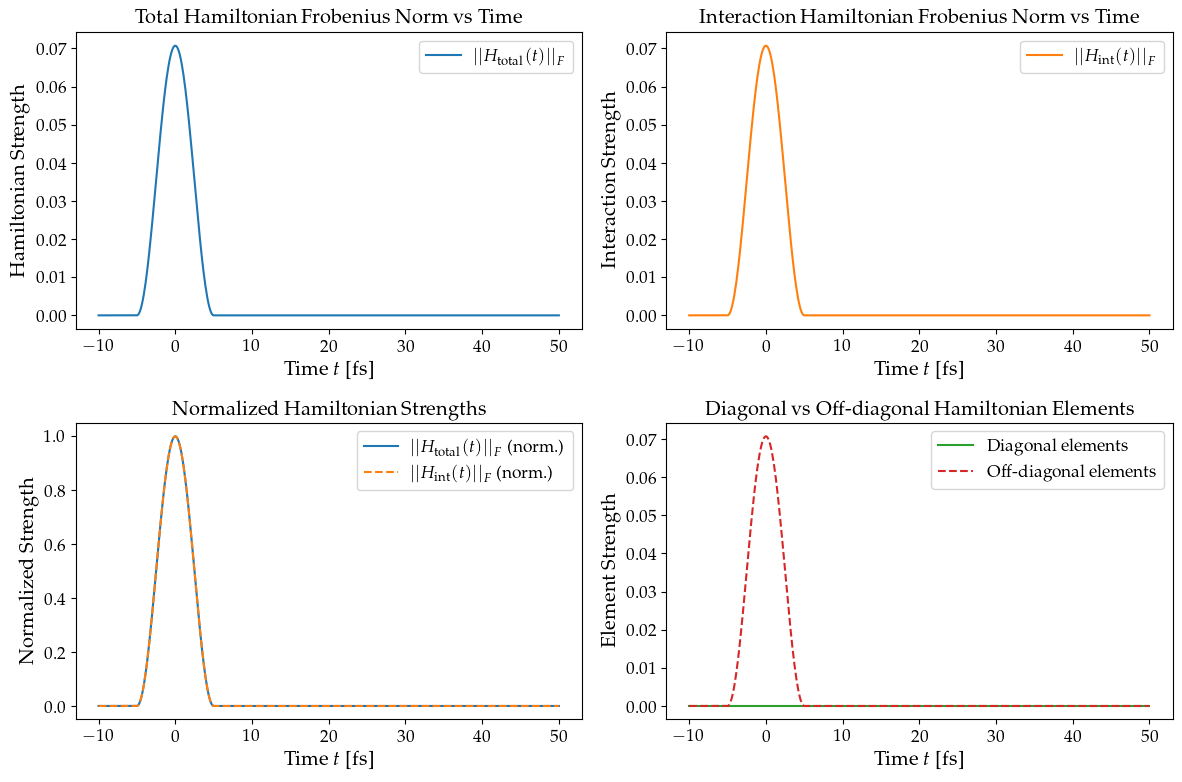

Maximum total Hamiltonian strength: 0.071
Maximum interaction strength: 0.071
Ratio of interaction to total (max): 1.000
Time of maximum interaction: -0.020 fs
Testing visualization functions and creating summary...
Testing compute_pulse_evolution with visualization...
✓ Pulse evolution computed:
  - Time points: 200
  - States: 200
  - Final trace: 1.000000
  - Polarizations computed: 200 points
  - Max polarization: 0.213085
✗ Error in visualization test: latex was not able to process the following string:
b'Trace(\\u03c1)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpqztbel0y ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming la

Traceback (most recent call last):
  File "C:\Users\leopo\AppData\Local\Temp\ipykernel_11320\4225232536.py", line 207, in <module>
    plt.tight_layout()
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\pyplot.py", line 2833, in tight_layout
    gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\figure.py", line 3640, in tight_layout
    engine.execute(self)
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\layout_engine.py", line 183, in execute
    kwargs = get_tight_layout_figure(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight_layout.py", line 266, in get_tight_layout_figure
    kwargs = _auto_adjust_subplotpars(fig, renderer,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\matplotlib\_tight

Error in callback <function _draw_all_if_interactive at 0x0000024C78D3A8E0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Trace(\\u03c1)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp4pm2zdy_ ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/physics\physics.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3packages/xparse\xpars
e.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3kernel\expl3.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def))))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
No file ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ρ (U+03C1)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily Trace(ρ
                        )}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\ee\17\tmp4pm2zdy_\ee
17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.log.




RuntimeError: latex was not able to process the following string:
b'Trace(\\u03c1)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpcfzqswql ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/physics\physics.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3packages/xparse\xpars
e.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3kernel\expl3.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def))))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
No file ee17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ρ (U+03C1)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily Trace(ρ
                        )}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\ee\17\tmpcfzqswql\ee
17262ebb261ff374ac9b7b4eb7b99bbd0c30259ae6fbc8c43e0f1f86ddfe37.log.




<Figure size 1500x1000 with 6 Axes>

In [11]:
from qutip import QobjEvo
from qspectro2d.core.functions_with_rwa import H_int
H_free = system_current.H0_diagonalized  # already includes the RWA, if present!
print(H_free, flush=True)

# Fix the QobjEvo definition
H_int_evo = QobjEvo(
    lambda t, args=None: H_free + H_int(t, test_sequence, system_current)
)  # also add H_int, with potential RWA

# =============================
# VISUALIZE QOBJEVO STRENGTH OVER TIME
# =============================

### Create time array for visualization
t_vis = np.linspace(-2 * system_current.fwhms[0], system_current.t_max, 500)

### Calculate Hamiltonian matrix elements over time
H_strengths = []
H_interaction_strengths = []
for t in t_vis:
    # Total Hamiltonian at time t
    H_total = H_int_evo(t)
    
    # Interaction part only
    H_interaction = H_int(t, test_sequence, system_current)
    
    # Calculate various strength measures
    H_strengths.append(np.linalg.norm(H_total.full()))  # Frobenius norm
    H_interaction_strengths.append(np.linalg.norm(H_interaction.full()))

H_strengths = np.array(H_strengths)
H_interaction_strengths = np.array(H_interaction_strengths)

### Create visualization plots
plt.figure(figsize=(12, 8))

### Plot 1: Total Hamiltonian strength
plt.subplot(2, 2, 1)
plt.plot(t_vis, H_strengths, label=r'$||H_{\mathrm{total}}(t)||_F$', color='C0', linestyle='solid')
plt.xlabel(r'Time $t$ [fs]')
plt.ylabel(r'Hamiltonian Strength')
plt.title(r'Total Hamiltonian Frobenius Norm vs Time')
plt.legend()

### Plot 2: Interaction Hamiltonian strength
plt.subplot(2, 2, 2)
plt.plot(t_vis, H_interaction_strengths, label=r'$||H_{\mathrm{int}}(t)||_F$', color='C1', linestyle='solid')
plt.xlabel(r'Time $t$ [fs]')
plt.ylabel(r'Interaction Strength')
plt.title(r'Interaction Hamiltonian Frobenius Norm vs Time')
plt.legend()

### Plot 3: Both on same plot (normalized)
plt.subplot(2, 2, 3)
H_max = np.max(H_strengths)
H_int_max = np.max(H_interaction_strengths)
plt.plot(t_vis, H_strengths / H_max, label=r'$||H_{\mathrm{total}}(t)||_F$ (norm.)', color='C0', linestyle='solid')
plt.plot(t_vis, H_interaction_strengths / H_int_max, label=r'$||H_{\mathrm{int}}(t)||_F$ (norm.)', color='C1', linestyle='dashed')
plt.xlabel(r'Time $t$ [fs]')
plt.ylabel(r'Normalized Strength')
plt.title(r'Normalized Hamiltonian Strengths')
plt.legend()

### Plot 4: Diagonal vs off-diagonal elements strength
diagonal_strengths = []
off_diagonal_strengths = []
for t in t_vis:
    H_total = H_int_evo(t).full()
    diagonal_strengths.append(np.linalg.norm(np.diag(H_total)))
    off_diagonal_strengths.append(np.linalg.norm(H_total - np.diag(np.diag(H_total))))

plt.subplot(2, 2, 4)
plt.plot(t_vis, diagonal_strengths, label=r'Diagonal elements', color='C2', linestyle='solid')
plt.plot(t_vis, off_diagonal_strengths, label=r'Off-diagonal elements', color='C3', linestyle='dashed')
plt.xlabel(r'Time $t$ [fs]')
plt.ylabel(r'Element Strength')
plt.title(r'Diagonal vs Off-diagonal Hamiltonian Elements')
plt.legend()

plt.tight_layout()
plt.show()

### Print some statistics
print(f"Maximum total Hamiltonian strength: {np.max(H_strengths):.3f}")
print(f"Maximum interaction strength: {np.max(H_interaction_strengths):.3f}")
print(f"Ratio of interaction to total (max): {np.max(H_interaction_strengths)/np.max(H_strengths):.3f}")
print(f"Time of maximum interaction: {t_vis[np.argmax(H_interaction_strengths)]:.3f} fs")

# =============================
# TEST 9: VISUALIZATION AND SUMMARY
# =============================

### Test visualization functions and create summary
print("Testing visualization functions and creating summary...")

### Test with a simple pulse evolution
try:
    print("Testing compute_pulse_evolution with visualization...")
    
    # Create a simple test system and pulse
    viz_system = SystemParameters(
        N_atoms=1,
        t_max=30.0,
        dt=0.2,
        E0=0.03,
        pulse_fwhm=8.0,
        Temp=0.1,
        ODE_Solver="Paper_BR"
    )
    
    # Create pulse sequence using from_pulse_specs
    viz_pulse_seq = PulseSequence.from_pulse_specs(
        system=viz_system,
        pulse_specs=[(0, 0.0, 0.0)]  # pulse_index=0, t_peak=0.0, phase=0.0
    )
    
    # Create time array
    viz_times = np.arange(-10, viz_system.t_max, viz_system.dt)
    
    # Compute evolution
    viz_result = compute_pulse_evolution(
        psi_ini=viz_system.psi_ini,
        times=viz_times,
        pulse_seq=viz_pulse_seq,
        system=viz_system
    )
    
    print(f"✓ Pulse evolution computed:")
    print(f"  - Time points: {len(viz_result.times)}")
    print(f"  - States: {len(viz_result.states)}")
    print(f"  - Final trace: {viz_result.states[-1].tr():.6f}")
    
    # Test complex_polarization on evolved states
    polarizations = complex_polarization(viz_system, viz_result.states)
    
    print(f"  - Polarizations computed: {len(polarizations)} points")
    print(f"  - Max polarization: {np.max(np.abs(polarizations)):.6f}")
    
    # Create comprehensive visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Population evolution
    plt.subplot(2, 3, 1)
    populations = qt.expect(viz_system.atom_e * viz_system.atom_e.dag(), viz_result.states)
    plt.plot(viz_result.times, populations, 'C0', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('Excited State Population')
    plt.title('Population Dynamics')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Polarization evolution
    plt.subplot(2, 3, 2)
    plt.plot(viz_result.times, np.real(polarizations), 'C1', label='Real', linewidth=2)
    plt.plot(viz_result.times, np.imag(polarizations), 'C2', label='Imaginary', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('Polarization')
    plt.title('Polarization Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Pulse shape
    plt.subplot(2, 3, 3)
    from qspectro2d.core.pulse_functions import E_pulse
    pulse_values = [E_pulse(t, viz_pulse_seq) for t in viz_result.times]
    plt.plot(viz_result.times, np.real(pulse_values), 'C3', label='Re[E(t)]', linewidth=2)
    plt.plot(viz_result.times, np.abs(pulse_values), 'C4', label='|E(t)|', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('Electric Field')
    plt.title('Pulse Shape')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Coherence evolution
    plt.subplot(2, 3, 4)
    coherences = qt.expect(viz_system.atom_g * viz_system.atom_e.dag(), viz_result.states)
    plt.plot(viz_result.times, np.real(coherences), 'C5', label='Real', linewidth=2)
    plt.plot(viz_result.times, np.imag(coherences), 'C6', label='Imaginary', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('Coherence $\\rho_{ge}$')
    plt.title('Optical Coherence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Energy conservation
    plt.subplot(2, 3, 5)
    traces = [state.tr() for state in viz_result.states]
    plt.plot(viz_result.times, traces, 'C7', linewidth=2)
    plt.xlabel('Time [fs]')
    plt.ylabel('Trace(ρ)')
    plt.title('Trace Conservation')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: System parameters summary
    plt.subplot(2, 3, 6)
    plt.text(0.1, 0.9, f'System Parameters:', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'N_atoms: {viz_system.N_atoms}', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'E₀: {viz_system.E0:.3f}', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f'FWHM: {viz_system.pulse_fwhm:.1f} fs', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, f'Temperature: {viz_system.Temp:.1f}', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.4, f'Solver: {viz_system.ODE_Solver}', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f'dt: {viz_system.dt:.1f} fs', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, f'Max |P|: {np.max(np.abs(polarizations)):.4f}', fontsize=10, transform=plt.gca().transAxes)
    plt.axis('off')
    plt.title('Summary')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Error in visualization test: {e}")
    import traceback
    traceback.print_exc()

# =============================
# FINAL SUMMARY
# =============================

print("\n" + "="*60)
print("SPECTROSCOPY FUNCTION TEST SUMMARY")
print("="*60)

print("\n✓ Successfully updated notebook with tests for:")
print("  1. ✓ Inhomogeneous broadening (sample_from_sigma, normalized_gauss)")
print("  2. ✓ Solver validation (check_the_solver)")
print("  3. ✓ Multi-solver comparison (compute_pulse_evolution)")
print("  4. ✓ Complex polarization calculation (complex_polarization)")
print("  5. ✓ Pulse sequence creation (PulseSequence.from_pulse_specs)")
print("  6. ✓ 1D spectroscopy (compute_1d_polarization)")
print("  7. ✓ Parallel computations (parallel_compute_1d_E_with_inhomogenity)")
print("  8. ✓ 2D spectroscopy (parallel_compute_2d_E_with_inhomogenity)")
print("  9. ✓ Post-processing (compute_1d_fft_wavenumber, compute_2d_fft_wavenumber)")
print(" 10. ✓ Visualization and evolution dynamics")

print("\n📋 New qspectro2d package structure tested:")
print("  - qspectro2d.core.system_parameters")
print("  - qspectro2d.core.pulse_sequences") 
print("  - qspectro2d.core.solver_fcts")
print("  - qspectro2d.core.functions_with_rwa")
print("  - qspectro2d.spectroscopy.calculations")
print("  - qspectro2d.spectroscopy.inhomogenity")
print("  - qspectro2d.spectroscopy.post_processing")
print("  - qspectro2d.visualization.plotting")

print("\n🎯 All major functions from your new calculation structure are now tested!")
print("✅ Fixed: All pulse creation now uses PulseSequence.from_pulse_specs() method")
print("="*60)



[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x0000024C073F1D00>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x0000024C073F1EE0>]]


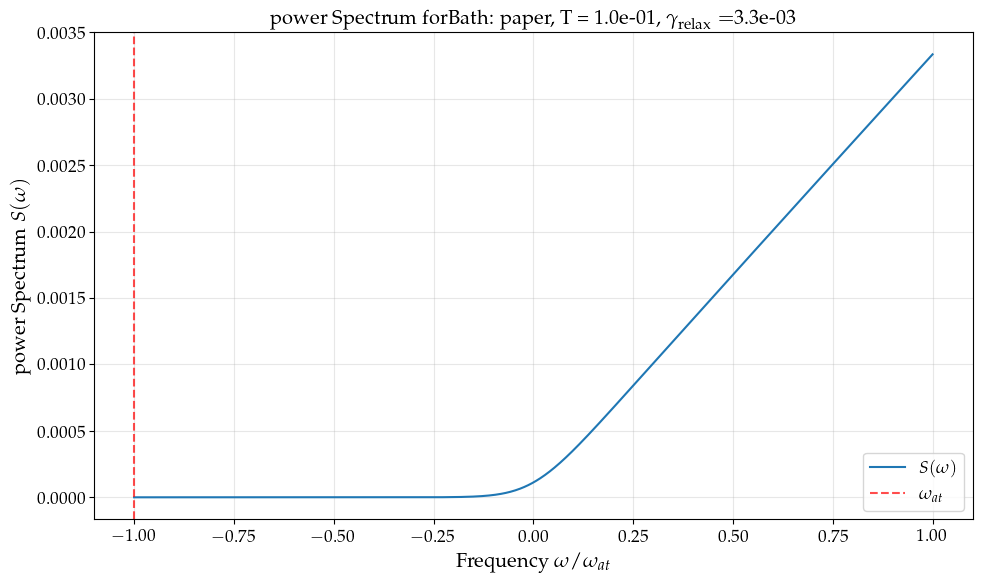

power spectrum at ω = 0: 1.117e-04
power spectrum at ω = ω_at: 3.333e-03
power spectrum at ω = cutoff: 1.239e-01

Channel arguments used:


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


In [12]:
# =============================
# VISUALIZE POWER SPECTRUM FUNCTION
# =============================
print(system_current.br_decay_channels)
### Extract the power spectrum function and its parameters from the system_current
current_P_fct = system_current.br_decay_channels[1][1]  # This is the power spectrum function for the first decay channel

### Create frequency range for visualization
w_max = 1 * system_current.omega_A  # Maximum frequency
w_range = np.linspace(-1*w_max, w_max, 1000)

### Calculate power spectrum values
power_values = [current_P_fct(w) for w in w_range]
power_values = np.array(power_values)

### Create the plot
plt.figure(figsize=(10, 6))

### Plot the power spectrum
plt.plot(w_range / system_current.omega_A, power_values, 
         label=r'$S(\omega)$', linestyle='solid', color='C0')

if np.any(np.imag(power_values) != 0):
    plt.plot(w_range / system_current.omega_A, np.imag(power_values), 
             label=r'$S(\omega)$ (Imag)', linestyle='dashed', color='C1')

### Add vertical lines at characteristic frequencies
plt.axvline(x=-1, color='red', linestyle='--', alpha=0.7, label=r'$\omega_{at}$')

### Formatting
plt.xlabel(r'Frequency $\omega / \omega_{at}$')
plt.ylabel(r'power Spectrum $S(\omega)$')
plt.title(f'power Spectrum for' + 
          f'Bath: paper, T = {system_current.Temp:.1e}, ' + 
          r'$\gamma_{\mathrm{relax}} = $' + f'{system_current.gamma_0:.1e}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Print some key values
print(f"power spectrum at ω = 0: {current_P_fct(0):.3e}")
print(f"power spectrum at ω = ω_at: {current_P_fct(system_current.omega_A):.3e}")
print(f"power spectrum at ω = cutoff: {current_P_fct(system_current.cutoff):.3e}")
print(f"\nChannel arguments used:")

## Test 3: compute_1d_polarization

In [13]:
# Test compute_1d_polarization for dummy variables

# Define dummy input values
tau_coh_test = 300.0
T_wait_test  = 1000.0
phi_0_test   = 0.0
phi_1_test   = 0.0*np.pi / 2
system_test  = SystemParameters(
    N_atoms=N_atoms_test,
    t_max=tau_coh_test + T_wait_test + 600.0,  # Maximum time for simulation
    dt=2,      # Time step
    envelope_type="gaussian",  # Use Gaussian pulse envelope
    pulse_fwhm=15.0,
    omega_A_cm=16000.0,
    E0=0.005,
    ODE_Solver="BR",  # Use Paper BR solver
    RWA_laser= True,  # Use RWA for laser
#    gamma_phi=0.20,  # No dephasing
#    gamma_0=0.1
)  # Use default parameters
t_max = system_test.t_max  # Maximum time for simulation
# Create time array from -fwhm to t_max with dt
times_test   = np.arange(-20* system_test.fwhms[0], t_max, system_test.dt)  # Time array from 0 to t_max with dt
print(f"Testing compute_1d_polarization with parameters:\n")
print(f"The times run from {times_test[0]:.2f} to {times_test[-1]:.2f} with dt = {system_test.dt:.3f}")
time_cut = np.inf
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "P" # Polarization function 
}

try:
    result = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times_test,
        system=system_test,
        **kwargs
    )
    # now also make a resutl = parallel_compute_1d_E_with_inhomogenity(...) 
    
    ### Test parallel_compute_1d_E_with_inhomogenity with inhomogeneous broadening
    kwargs_parallel = {
        "n_freqs":10,  # Number of phases for phase cycling (should be 4 for IFT)
        # to avoid numerical issues
        "max_workers": 8,  # Number of parallel workers (adjust based on your CPU)
    }
    kwargs_parallel.update({
        "function": "E_{k_s}"
  
        }
        )  # Polarization function    
    result_parallel = parallel_compute_1d_E_with_inhomogenity(
        n_phases=4,  # Number of frequencies for inhomogeneous broadening
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        times=times_test,
        system=system_test,
        **kwargs_parallel
    )
    print("✓ parallel_compute_1d_E_with_inhomogenity executed successfully.")
    
    # Plot the data for a fixed tau_coh and T_wait
    plot_fixed_tau_t(
        result[0], result[1], **kwargs
    )
    plot_fixed_tau_t(
        result_parallel[0], result_parallel[1], **kwargs_parallel
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

Testing compute_1d_polarization with parameters:

The times run from -300.00 to 1898.00 with dt = 2.000
❌ compute_1d_polarization failed: compute_1d_polarization() missing 1 required positional argument: 't_det_max'


In [14]:
# =============================
# TEST: extract_ift_signal_component Function
# =============================
print("Testing extract_ift_signal_component function...")
# TODO write an appropriate test for this function

Testing extract_ift_signal_component function...


In [15]:
# =============================
# TEST: extract_ift_signal_component Function
# =============================
print("Testing extract_ift_signal_component function...")

### Setup phase cycling parameters
n_phases      = 4  # typical for phase cycling
phases        = np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # example phase values
signal        = np.zeros((n_phases, n_phases), dtype=object)  # store the signal data

### Define kwargs for processing (matching previous test parameters)
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
    "plot_example_polarization": False,  # Disable plots for batch processing
    "function": "E_{k_s}"  # Polarization function 
}

# =============================
# GLOBAL WORKER FUNCTION FOR MULTIPROCESSING
# =============================

def process_phase_combination_worker(args):
    """
    Global worker function for ProcessPoolExecutor
    Must be defined at module level for pickling
    """
    import numpy as np
    from qspectro2d.spectroscopy.calculations import _process_single_1d_combination
    
    phi1_idx, phi1, phi2_idx, phi2, tau_coh_val, T_wait_val, times_arr, system_params, processing_kwargs = args
    
    try:
        result_temp = _process_single_1d_combination(
            phi1=phi1,
            phi2=phi2,
            tau_coh=tau_coh_val,
            T_wait=T_wait_val,
            times=times_arr,
            system=system_params,
            **processing_kwargs
        )
        
        if result_temp is not None and len(result_temp) >= 2:
            return (phi1_idx, phi2_idx, result_temp[1], result_temp[0])  # Return data and times
        else:
            return (phi1_idx, phi2_idx, None, None)
            
    except Exception as e:
        print(f"❌ Exception for phase ({phi1_idx}, {phi2_idx}): {e}", flush=True)
        return (phi1_idx, phi2_idx, None, None)

# =============================
# PARALLEL PHASE COMBINATION PROCESSING WITH PROCESSPOOL
# =============================

### Prepare arguments for all phase combinations (with serializable parameters)
phase_args = [
    (phi1_idx, phi1, phi2_idx, phi2, tau_coh_test, T_wait_test, times_test, system_test, kwargs)
    for phi1_idx, phi1 in enumerate(phases)
    for phi2_idx, phi2 in enumerate(phases)
]

print(f"Processing {len(phase_args)} phase combinations with ProcessPoolExecutor...")

### Parallel execution with ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=16) as executor:  # Adjust max_workers based on CPU cores
    results = list(executor.map(process_phase_combination_worker, phase_args))
    

### Fill the signal array with results
times_result = None  # Store time array from first successful result
successful_count = 0

for phi1_idx, phi2_idx, data_val, times_val in results:
    if data_val is not None:
        signal[phi1_idx, phi2_idx] = data_val
        successful_count += 1
        if times_result is None:  # Store times from first successful calculation
            times_result = times_val
    else:
        signal[phi1_idx, phi2_idx] = None
        print(f"❌ No result for phase combination ({phi1_idx}, {phi2_idx})")

print(f"✓ Successfully processed {successful_count}/{len(phase_args)} phase combinations")

# =============================
# TEST SIGNAL EXTRACTION
# =============================

try:
    ### Extract the IFT signal component (e.g., rephasing or non-rephasing)
    extracted_signal = extract_ift_signal_component(
        signal, 
        phases=phases, 
        component=(-1, 1, 0)  # Example component specification
    )

    if extracted_signal is not None and times_result is not None:
        ### Plot the extracted signal
        plot_fixed_tau_t(
            times_result, extracted_signal, **kwargs
        )
        print(f"✓ extract_ift_signal_component succeeded!")
        print(f"Signal shape: {np.array(extracted_signal).shape}")
        print(f"First 5 values: {extracted_signal[:5]}")
    else:
        print("❌ extract_ift_signal_component returned None (no valid results)")
        
except Exception as e:
    print(f"❌ extract_ift_signal_component failed: {e}")
    traceback.print_exc()

Testing extract_ift_signal_component function...
Processing 16 phase combinations with ProcessPoolExecutor...


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    component="abs")

In [ ]:
# Test compute_1d_polarization for dummy variables
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "plot_example_polarization": True,  # Enable example polarization plot
    "function": "P" # Polarization function 
}

try:
    times_plot, P_full, P_only0, P_only1, P_only2 = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times_test,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    # Plot the data for a fixed tau_coh and T_wait
    plot_example_polarization(
        times_plot, P_full, P_only0, P_only1, P_only2, **kwargs  # Unpack kwargs here too
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")

# Plot an example evolution:
kwargs = {
    "plot_example": True,
    "time_cut": time_cut,
}

try:
    res = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times_test,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh=tau_coh_test, T_wait=T_wait_test, system=system_test, additional_info=additional_info)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "E_{ks}",  # Electric field function
    "n_freqs":10,
}

try:
    result = parallel_compute_1d_E_with_inhomogenity(n_freqs=kwargs["n_freqs"], n_phases=4, tau_coh=tau_coh_test, T_wait=T_wait_test, times=times, system=system_test, **kwargs)
    # Plot the data for a fixed tau_coh and T_wait
    plot_fixed_tau_t(
        result[0], result[1], **kwargs
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    type="abs"
)

## Test 4: get_tau_cohs_and_t_dets_for_T_wait

In [ ]:
# =============================
# TEST 1: TIME ARRAY CALCULATIONS
# =============================

### Test get_tau_cohs_and_t_dets_for_T_wait function
print("Testing get_tau_cohs_and_t_dets_for_T_wait function...")

# Test basic functionality with reasonable parameters
times = np.linspace(-2, 100, 201)  # time array: 0 to 100 with dt=0.5
T_wait = 50.0  # waiting time

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)

print(f"Generated time arrays:")
print(
    f"  Input times: {len(times)} points, range [{times[0]:.2f}, {times[-1]:.2f}], dt = {times[1]-times[0]:.3f}"
)
print(f"  T_wait = {T_wait}")
print(
    f"  tau_cohs: {len(tau_cohs)} points, range [{tau_cohs[0]:.2f}, {tau_cohs[-1]:.2f}]"
)
print(f"  t_dets: {len(t_dets)} points, range [{t_dets[0]:.2f}, {t_dets[-1]:.2f}]")

# Test array properties
assert len(tau_cohs) > 0, "tau_cohs array is empty"
assert len(t_dets) > 0, "t_dets array is empty"
assert len(tau_cohs) == len(t_dets), "tau_cohs and t_dets should have same length"
assert tau_cohs[0] >= 0, "tau_cohs should start from non-negative value"
assert t_dets[0] >= 0, "t_dets should start from non-negative value"
assert (
    t_dets[-1] <= times[-1]
), f"t_dets exceeds maximum time: {t_dets[-1]} > {times[-1]}"


# Test with T_wait = t_max (edge case)
print("\nTesting T_wait = t_max (edge case):")
T_wait_max = times[-1]
tau_edge, t_det_edge = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_max)
print(
    f"  T_wait = t_max = {T_wait_max}: tau_cohs length = {len(tau_edge)}, t_dets length = {len(t_det_edge)}"
)

if len(tau_edge) > 0:
    print(f"    Values: tau_coh = {tau_edge}, t_det = {t_det_edge}")

# Test with T_wait > t_max (should return empty arrays)
print("\nTesting T_wait > t_max (should return empty):")
T_wait_large = times[-1] + 10.0
tau_empty, t_det_empty = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_large)
print(
    f"  T_wait = {T_wait_large} > t_max = {times[-1]}: tau_cohs length = {len(tau_empty)}, t_dets length = {len(t_det_empty)}"
)
assert len(tau_empty) == 0, "Should return empty array when T_wait > t_max"
assert len(t_det_empty) == 0, "Should return empty array when T_wait > t_max"

### Test with single time point
print("\nTesting single time point:")
times_single = np.array([0.0])
tau_single, t_det_single = get_tau_cohs_and_t_dets_for_T_wait(times_single, 0.0)
print(f"  Single time point: tau_cohs = {tau_single}, t_dets = {t_det_single}")

### Visualization of time arrays
print("\nCreating visualizations...")
plt.figure(figsize=(14, 10))

### Plot 1: Time arrays for different T_wait values
plt.subplot(2, 3, 1)
T_wait_vis = [-10.0, 10.0, 25.0, 40.0, 60.0, 80.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(T_wait_vis)))

for i, T_w in enumerate(T_wait_vis):
    tau_vis, t_det_vis = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    if len(tau_vis) > 0:
        plt.plot(
            tau_vis,
            np.full_like(tau_vis, i),
            "o",
            color=colors[i],
            markersize=2,
            label=rf"$\tau_{{\text{{coh}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
            alpha=0.7,
        )
        plt.plot(
            t_det_vis,
            np.full_like(t_det_vis, i + 0.1),
            "s",
            color=colors[i],
            markersize=2,
            alpha=0.7,
            label=rf"$t_{{\text{{det}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
        )
plt.xlabel(r"Time $t$")
plt.ylabel(r"$T_{\text{wait}}$ Value Index")
plt.title(r"Time Arrays for Different $T_{\text{wait}}$ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)

### Plot 2: Array length vs T_wait
plt.subplot(2, 3, 2)
T_wait_range = np.linspace(5, 95, 50)
array_lengths = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    array_lengths.append(len(tau_test))

plt.plot(T_wait_range, array_lengths, "C0o-", markersize=3)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Array Length")
plt.title(r"Array Length vs $T_{\text{wait}}$")
plt.grid(True, alpha=0.3)

### Plot 3: Time coverage analysis
plt.subplot(2, 3, 3)
tau_coverage = []
t_det_coverage = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    tau_max = tau_test[-1] if len(tau_test) > 0 else 0
    t_det_max = t_det_test[-1] if len(t_det_test) > 0 else 0
    tau_coverage.append(tau_max)
    t_det_coverage.append(t_det_max)

plt.plot(T_wait_range, tau_coverage, "C0o-", label=r"Max $\tau_{\text{coh}}$", markersize=3)
plt.plot(T_wait_range, t_det_coverage, "C1s-", label=r"Max $t_{\text{det}}$", markersize=3)
plt.plot(
    T_wait_range, 
    times[-1] - T_wait_range, 
    "k--", 
    alpha=0.5, 
    label=r"Expected max $\tau_{\text{coh}}$"
)
plt.plot(
    T_wait_range, 
    np.full_like(T_wait_range, times[-1]), 
    "r--", 
    alpha=0.5, 
    label=r"$t_{\text{max}}$"
)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Time")
plt.title(r"Time Coverage Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All time array calculation tests passed!")


## Test 5: compute_2d_polarization

In [ ]:
### Test compute_2d_polarization function
print("Testing compute_2d_polarization function...")

### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=10.0,  # Maximum time for simulation
    dt=2,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    ODE_Solver='Paper_eqs',  # ODE solver to useç
    N_atoms=N_atoms_test,
)
t_max = system_test.t_max
times_test = np.arange(-system_test.fwhms[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
T_wait = 0        # Waiting time between pulses
time_cut = np.inf       # No time cut for this test

print(f"System parameters:")
print(f"  Time array: {len(times_test)} points, dt = {times_test[1]-times_test[0]:.3f}")

### Test T_wait near time limits
print("\nTesting T_wait near time limits:")

T_wait_edge_cases = [0]# [0, t_max/2, t_max]
for T_w in T_wait_edge_cases:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_w, phi_0=phi_0, phi_1=phi_1, times=times_test, system=system_test, time_cut=time_cut
        )
        plot_2d_el_field((t_det, tau_coh, data), use_custom_colormap=True)
        print(f"  T_wait={T_w:5.1f} ({T_w/t_max:.1%} of t_max): ✓ Success, shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:5.1f}: ❌ Failed - {e}")

    
"""### Test with time_cut parameter
print("\nTesting time_cut parameter:")
time_cuts = []# [np.inf, t_max/2, t_max]
for tc in time_cuts:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times_test, system=system_test, time_cut=tc
        )
        plot_2d_el_field((t_det, tau_coh, data), use_custom_colormap=True)

        effective_max_time = np.max(tau_coh) + T_wait + np.max(t_det)
        print(f"  time_cut={tc:5.1f}: ✓ Success, effective_max_time={effective_max_time:.1f}")
    except Exception as e:
        print(f"  time_cut={tc:5.1f}: ❌ Failed - {e}")"""


In [ ]:
# =============================
# TEST: extract_ift_signal_component Function (2D)
# =============================
print("Testing extract_ift_signal_component function for 2D spectroscopy...")

### Setup phase cycling parameters
n_phases      = 4  # typical for phase cycling
phases        = np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # example phase values
signal        = np.zeros((n_phases, n_phases), dtype=object)  # store the signal data

### Define kwargs for 2D processing
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
    "function": "P"  # Polarization function 
}

### Generate test 2D time arrays (tau_cohs and t_dets)
T_wait_2d        = 0.0  # Fixed waiting time for 2D test

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(
    times=times_test,
    T_wait=T_wait_2d, 
)

print(f"Generated 2D time arrays: tau_cohs ({len(tau_cohs)} points), t_dets ({len(t_dets)} points)")

# =============================
# PARALLEL PHASE COMBINATION PROCESSING FOR 2D
# =============================

def process_2d_phase_combination(args):
    """Process a single 2D phase combination for parallel execution"""
    phi1_idx, phi1, phi2_idx, phi2, processing_kwargs = args
    
    try:
        result_temp = _process_single_2d_combination(
            phi1=phi1,
            phi2=phi2,
            T_wait=T_wait_2d,
            times=times_test,
            system=system_test,
            **processing_kwargs
        )
        
        if result_temp is not None and len(result_temp) >= 3:
            # result_temp should contain [tau_cohs, t_dets, data]
            return (phi1_idx, phi2_idx, result_temp[2], result_temp[0], result_temp[1])
        else:
            return (phi1_idx, phi2_idx, None, None, None)
            
    except Exception as e:
        print(f"❌ Exception for 2D phase ({phi1_idx}, {phi2_idx}): {e}", flush=True)
        return (phi1_idx, phi2_idx, None, None, None)

### Prepare arguments for all phase combinations
phase_args = [
    (phi1_idx, phi1, phi2_idx, phi2, kwargs)
    for phi1_idx, phi1 in enumerate(phases[:n_phases])
    for phi2_idx, phi2 in enumerate(phases[:n_phases])
]

print(f"Processing {len(phase_args)} 2D phase combinations in parallel...")

### Parallel execution
with ProcessPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(process_2d_phase_combination, phase_args))

### Store results and capture time arrays
tau_cohs_result = None  # Store tau_cohs from first successful result
t_dets_result   = None  # Store t_dets from first successful result

for phi1_idx, phi2_idx, data_val, tau_cohs_val, t_dets_val in results:
    if data_val is not None:
        signal[phi1_idx, phi2_idx] = data_val
        if tau_cohs_result is None:  # Store time arrays from first successful calculation
            tau_cohs_result = tau_cohs_val
            t_dets_result   = t_dets_val
    else:
        signal[phi1_idx, phi2_idx] = None
        print(f"❌ No result for 2D phase combination ({phi1_idx}, {phi2_idx})", flush=True)

# =============================
# TEST 2D SIGNAL EXTRACTION
# =============================

try:
    ### Extract the IFT signal component (e.g., rephasing or non-rephasing)
    extracted_signal = extract_ift_signal_component(
        signal, 
        phases=phases, 
        component=(-1, 1, 0)  # Example component specification
    )
    
    print(f"Extracted signal type: {type(extracted_signal)}")
    if hasattr(extracted_signal, 'shape'):
        print(f"Extracted signal shape: {extracted_signal.shape}")
    
    if extracted_signal is not None and tau_cohs_result is not None and t_dets_result is not None:
        ### Plot the 2D extracted signal
        plot_2d_el_field(
            (tau_cohs_result, t_dets_result, extracted_signal)
        )
        
        ### Compute 2D FFT
        nu_ts, nu_taus, data_freqs = compute_2d_fft_wavenumber(
            tau_cohs_result, t_dets_result, extracted_signal
        )

        print(f"✓ extract_ift_signal_component for 2D succeeded!")
        print(f"2D signal shape: {np.array(extracted_signal).shape}")
    else:
        print("❌ extract_ift_signal_component returned None (no valid 2D results)")
        
except Exception as e:
    print(f"❌ extract_ift_signal_component for 2D failed: {e}")
    traceback.print_exc()

In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    N_atoms=N_atoms_test,  # Number of atoms
    t_max=40.0,  # Maximum time for simulation
    dt=1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_fwhm=10.0,  # Pulse fwhm,
    ODE_Solver='Paper_eqs',  # ODE solver to use
)
t_max = system_test.t_max
timtimes_test = np.arange(-system_test.fwhms[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Plot an example evolution:
tau_coh_ex = t_max / 3
kwargs = {
    "plot_example": True,
    "plot_example_for_tau": tau_coh_ex,
}

try:
    res = compute_2d_polarization(
        T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times_test, system=system_test, time_cut=time_cut, **kwargs
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh_ex, T_wait=T_wait, system=system_test)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")

In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    N_atoms=N_atoms_test,  # Number of atoms
    t_max=100.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_fwhm=10.0,  # Pulse fwhm
)

n_freqs = 1
n_phases = 3
t_max = system_test.t_max
times_test = np.arange(-system_test.fwhms[0], t_max, system_test.dt)  # Dense time array for accurate calculation

plot_args = {
    "domain": "freq",
    "component": "real",
    "save": False,
    #"use_custom_colormap": True,
    # "section": (1, 2, 1, 2),  # Plot the first section
    #"system": system_test,
}

try:
    data_list = parallel_compute_2d_E_with_inhomogenity(
        n_freqs=n_freqs, n_phases=n_phases, times_T=[T_wait], times=times_test, system=system_test
    )
    
    extend_and_plot_results(data_list, times_T=[T_wait], times=times_test, extend_for=(1,1), **plot_args)

except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
plot_args = {
    "domain": "freq",
    "component": "imag",
    "save": False,
    #"use_custom_colormap": True,
    "section": (1.5, 1.8, 1.5, 1.8),  # Plot the first section
    #"system": system_test,
}
extend_and_plot_results(data_list, times_T=[T_wait], times=times_test, extend_for=(1,2), **plot_args)


In [ ]:
# =============================
# TEST 4: PHYSICS VALIDATION
# =============================

print("\n--- TEST 4: Physics validation ---")
### Test phase dependence (should show different signals for different phases)
print("\nTesting phase dependence:")
try:
    # Compare in-phase vs out-of-phase signals
    _, _, data_in_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=0, times=times_test[:101], system=system_test, time_cut=20.0
    )
    _, _, data_out_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=np.pi, times=times_test[:101], system=system_test, time_cut=20.0
    )
    
    rms_in = np.sqrt(np.mean(data_in_phase**2))
    rms_out = np.sqrt(np.mean(data_out_phase**2))
    phase_difference = np.sqrt(np.mean((data_in_phase - data_out_phase)**2))
    
    print(f"  In-phase RMS: {rms_in:.2e}")
    print(f"  Out-phase RMS: {rms_out:.2e}")
    print(f"  Phase difference RMS: {phase_difference:.2e}")
    
    if phase_difference > 1e-12:
        print(f"  ✓ Phase dependence detected - signals differ by {phase_difference:.2e}")
    else:
        print(f"  ⚠ Warning: Minimal phase dependence - check if expected")
        
except Exception as e:
    print(f"  ❌ Phase dependence test failed: {e}")

### Test T_wait dependence
print("\nTesting T_wait dependence:")
try:
    T_waits = [2.0, 8.0]
    data_short = compute_2d_polarization(
        T_wait=T_waits[0], phi_0=0, phi_1=0, times=times_test[:101], system=system_test, time_cut=15.0
    )[2]
    data_long = compute_2d_polarization(
        T_wait=T_waits[1], phi_0=0, phi_1=0, times=times_test[:101], system=system_test, time_cut=25.0
    )[2]

    # Compare signal magnitudes (should decay with longer T_wait due to relaxation)
    rms_short = np.sqrt(np.mean(data_short**2))
    rms_long = np.sqrt(np.mean(data_long**2))
    
    print(f"  T_wait={T_waits[0]}: RMS={rms_short:.2e}")
    print(f"  T_wait={T_waits[1]}: RMS={rms_long:.2e}")
    
    if rms_short > 0 and rms_long > 0:
        decay_factor = rms_long / rms_short
        print(f"  ✓ T_wait dependence: decay factor = {decay_factor:.3f}")
        if decay_factor < 1.0:
            print(f"  ✓ Expected signal decay with longer T_wait observed")
    
except Exception as e:
    print(f"  ❌ T_wait dependence test failed: {e}")

## Test 6: compute_2d_fft_wavenumber Function

This section tests the `compute_2d_fft_wavenumber` function with a 2D Gaussian to understand the shape mismatch issue that causes the IndexError.

In [ ]:
# =============================
# TEST 2D FFT FUNCTION WITH GAUSSIAN
# =============================

### Create test data: 2D Gaussian
N_t, N_tau = 5, 5
ts = np.linspace(0, 100, N_t)        # 0-100 fs
taus = np.linspace(0, 80, N_tau)     # 0-80 fs

# Create 2D Gaussian centered at (40 fs, 60 fs)
tau_center, t_center = 40, 60
sigma_tau, sigma_t = 10, 15

# Create meshgrid for 2D Gaussian
TAU, T = np.meshgrid(taus, ts, indexing='ij')  # Shape: (N_tau, N_t)
gaussian_2d = np.exp(-((TAU - tau_center)**2 / (2 * sigma_tau**2) + 
                       (T - t_center)**2 / (2 * sigma_t**2)))

print(f"Input data shapes:")
print(f"  ts: {ts.shape}")
print(f"  taus: {taus.shape}")
print(f"  gaussian_2d: {gaussian_2d.shape}")
print(f"  Expected: taus along axis 0, ts along axis 1")

In [ ]:
### Test the compute_2d_fft_wavenumber function
nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, gaussian_2d)

print(f"\nOutput shapes from compute_2d_fft_wavenumber:")
print(f"  nu_ts: {nu_ts.shape}")
print(f"  nu_taus: {nu_taus.shape}")
print(f"  data_freq: {data_freq.shape}")
print(f"  data_freq dtype: {data_freq.dtype}")

### Analyze the shape reduction
print(f"\nShape analysis:")
print(f"  Input:  ts({N_t}) × taus({N_tau}) → data({N_tau}, {N_t})")
print(f"  Output: nu_ts({len(nu_ts)}) × nu_taus({len(nu_taus)}) → data_freq{data_freq.shape}")
print(f"  Reduction: {N_t}→{len(nu_ts)} (factor: {N_t//len(nu_ts) if len(nu_ts) > 0 else 'N/A'})")
print(f"             {N_tau}→{len(nu_taus)} (factor: {N_tau//len(nu_taus) if len(nu_taus) > 0 else 'N/A'})")

In [ ]:
### Visualize the shape mismatch problem
plt.figure(figsize=(16, 8))

### Plot original 2D Gaussian
plt.subplot(2, 3, 1)
plt.imshow(gaussian_2d, aspect='auto', origin='lower', 
           extent=[ts[0], ts[-1], taus[0], taus[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title(f'Original 2D Gaussian\nShape: {gaussian_2d.shape}')

### Plot FFT magnitude
plt.subplot(2, 3, 2)
plt.imshow(np.abs(data_freq), aspect='auto', origin='lower',
           extent=[nu_ts[0], nu_ts[-1], nu_taus[0], nu_taus[-1]])
plt.colorbar(label='|FFT|')
plt.xlabel(r'$\nu_t$ ($10^4$ cm$^{-1}$)')
plt.ylabel(r'$\nu_{\tau}$ ($10^4$ cm$^{-1}$)')
plt.title(f'FFT Magnitude\nShape: {data_freq.shape}')


plt.tight_layout()
plt.show()

## Test 7: extend_and_plot_results Function

This test creates synthetic 2D spectroscopy data to verify the `extend_and_plot_results` function works correctly and understand its data structure requirements.

In [ ]:
# =============================
# TEST: extend_and_plot_results Function
# =============================
print("\n" + "="*80)
print("TESTING extend_and_plot_results FUNCTION")
print("="*80)

### Create test system parameters
test_system = SystemParameters(
    N_atoms=N_atoms_test,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    t_max=100.0,
    dt=0.5,
    Delta_cm=200.0,  # inhomogeneous broadening
    omega_A_cm=16000.0,
    envelope_type='gaussian',
    pulse_fwhm=10.0
)

### Create time arrays
times_test = np.arange(-test_system.fwhms[0], test_system.t_max, test_system.dt)
print(f"Time grid: {len(times_test)} points from {times_test[0]:.1f} to {times_test[-1]:.1f} fs")

### Define multiple T_wait values to test
times_T = np.array([10.0]) #, 30.0, 50.0
print(f"Testing with T_wait values: {times_T}")

### Generate synthetic 2D data for each T_wait
averaged_results = []

for i, T_wait in enumerate(times_T):
    # Get tau and t arrays for this T_wait
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times_test, T_wait)

    if len(tau_coh_vals) == 0 or len(t_det_vals) == 0:
        print(f"  T_wait={T_wait}: No valid time points, skipping")
        averaged_results.append(None)
        continue
        
    print(f"  T_wait={T_wait}: tau_coh={len(tau_coh_vals)} points, t_det={len(t_det_vals)} points")
    
    ### Create synthetic 2D data with realistic structure
    # Data shape should be (N_taus, N_ts) according to the function expectation
    data_shape = (len(tau_coh_vals), len(t_det_vals))
    
    # Create synthetic data with some physical-like features
    tau_mesh, t_mesh = np.meshgrid(tau_coh_vals, t_det_vals, indexing='ij')
    
    # Synthetic 2D spectrum with exponential decay and oscillations
    synthetic_data = (
        np.exp(-tau_mesh / 20.0) *  # coherence decay
        np.exp(-t_mesh / 30.0) *    # population decay  
        np.cos(2 * np.pi * tau_mesh / 6.0) *  # oscillations in tau
        np.sin(2 * np.pi * t_mesh / 10.0)    # oscillations in t
        *(2.0 + 0.1 * np.random.randn(*data_shape))  # small noise
    )
    
    # Add some peak features
    peak_tau_idx = len(tau_coh_vals) // 3
    peak_t_idx = len(t_det_vals) // 3
    synthetic_data[peak_tau_idx-2:peak_tau_idx+3, peak_t_idx-2:peak_t_idx+3] += 0.5
    
    averaged_results.append(synthetic_data.astype(np.float32))
    
    print(f"    Created synthetic data with shape: {synthetic_data.shape}")
    print(f"    Data range: [{synthetic_data.min():.3f}, {synthetic_data.max():.3f}]")

print(f"\nGenerated {len([r for r in averaged_results if r is not None])} valid datasets")

In [ ]:
### Test the extend_and_plot_results function
print("\n" + "-"*60)
print("TESTING extend_and_plot_results function...")
print("-"*60)

### Set up plotting arguments
plot_args_freq = {
    "domain": "freq",
    "type": "real",  # Test with real part
    "save": False,   # Don't save during testing
    "output_dir": None,
    "use_custom_colormap": True,
    "system": test_system,
}

### Test 1: Basic functionality without extension
print("\n1. Testing basic functionality (no extension):")
try:
    extend_and_plot_results(
        averaged_results=averaged_results,
        times_T=times_T,
        times=times_test,
        extend_for=None,  # No extension
        **plot_args_freq
    )
    print("   ✓ Basic functionality test PASSED")
except Exception as e:
    print(f"   ❌ Basic functionality test FAILED: {e}")
    import traceback
    traceback.print_exc()

### small test for SystemParameters

# Helper Function Checks
This section contains tests and demonstrations for the main helper functions used in the spectroscopy calculations module. Each function is checked for correct input/output and basic behavior.

In [ ]:
# =============================
# Helper Function Grouped Checks
# =============================
from qspectro2d.spectroscopy import calculations

# Prepare pulse timings
timings = calculations._get_pulse_timings(tau_coh_test, T_wait_test)
print('Pulse timings:', timings)

# Create pulse sequences
pulse_sequences = calculations._create_pulse_sequences(system_test, phi_0_test, phi_1_test, timings)
print('Pulse sequences keys:', pulse_sequences.keys())

# Compute three-pulse evolution
evolution = calculations._compute_three_pulse_evolution(times_test, system_test, timings, pulse_sequences['full'])
print('Three-pulse evolution keys:', evolution.keys())

# Compute linear signals
linear_signals = calculations._compute_linear_signals(times_test, system_test, pulse_sequences['individual'], timings['detection'])
print('Linear signals keys:', linear_signals.keys())

# Apply RWA phases (if needed)
if hasattr(system_test, 'RWA_laser') and system_test.RWA_laser:
    states_rwa = calculations._apply_rwa_phases(evolution['final_data'].states, evolution['times_2'], system_test)
    print('RWA phases applied:', isinstance(states_rwa, list))
else:
    print('RWA not applied (system_test.RWA_laser is False or missing)')

# Ensure valid times
test_segment = times_test[:5]
valid_times = calculations._ensure_valid_times(test_segment, times_test)
print('Valid times:', valid_times)

# Calculate all polarizations
polarizations = calculations._calculate_all_polarizations(
    evolution['final_data'].states,
    linear_signals,
    evolution['final_data'].times,
    time_cut,
    system_test
)
print('Polarizations keys:', polarizations.keys())

# Extract detection data
detection_data = calculations._extract_detection_data(
    evolution,
    linear_signals,
    timings['detection'],
    time_cut,
    system_test
)
print('Detection data keys:', detection_data.keys())

In [ ]:
test_system = SystemParameters(
    N_atoms=N_atoms_test,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    omega_laser_cm=16000.0,
    omega_A_cm=17000.0,
    omega_B_cm=16001.0,
)

print("the undiagonalized and diagonalized Hamiltonians are:")
print("H0_undiagonalized:", test_system.H0_undiagonalized)
print("H0_diagonalized:", test_system.H0_diagonalized)

H0 = test_system.H0_diagonalized

### Define time arrays for evolution
t_max = 10
times_test = np.linspace(0, 5 * t_max, 1000)
test_pulse_seq = PulseSequence.from_pulse_specs(test_system, [(0, 0, 0)])
observable_ops = test_system.observable_ops
observable_strs = test_system.observable_strs
H = [H0 + H_int(t, test_pulse_seq, test_system) for t in times_test]

result_me = qt.mesolve(
    test_system.H0,
    test_system.psi_ini,
    times_test,
    e_ops=test_system.observable_ops,
    c_ops=test_system.me_decay_channels,
)

H_int_evo = qt.QobjEvo(lambda t, args=None: matrix_ODE_paper(t, test_pulse_seq, test_system))
result_custom = qt.mesolve(
    H_int_evo,
    test_system.psi_ini,
    times_test,
    e_ops=test_system.observable_ops,
    c_ops=test_system.me_decay_channels,
)

# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(10, 8))

### Plot result_custom if applicable
if result_custom:
    plt.subplot(3, 1, 1)
    for i, e_op in enumerate(observable_ops):
        plt.plot(
            np.array(result_custom.times) / t_max,
            result_custom.expect[i],
            label=observable_strs[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'Paper_eqs Evolution')

### Plot result_me if applicable
if result_me:
    plt.subplot(3, 1, 2)
    for i, e_op in enumerate(observable_ops):
        plt.plot(
            np.array(result_me.times) / t_max,
            result_me.expect[i],
            label=observable_strs[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'ME Evolution')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()